# Tercera ejercitación de Laboratorio de Datos

Para poder empezar a laburar, importo todos los paquetes que utilizaré más tarde.

In [2]:
import pandas as pd #Para manejo de base de datos.
import numpy as np #Para manejo de arrays, operaciones matemáticas, etc.
import matplotlib.pylab as plt #Para gráficos.
from sklearn.decomposition import PCA #Para realizar análisis de componentes principales.
from sklearn.preprocessing import StandardScaler #Para estandarizar: transforma las variables en z-scores.
from keras.datasets import mnist,fashion_mnist #Para importar el dataset.
# importamos los algoritmos de clusterizacion a utilizar en esta notebook
from sklearn.cluster import KMeans                    #Para hacer clusterización mediante el algoritmo de K-means
from sklearn.cluster import AgglomerativeClustering   #Para hacer clusterización jerárquica
from sklearn.neighbors import KNeighborsClassifier    #Para hacer KNN
from sklearn.metrics import confusion_matrix as cm    #Para poder construir una matriz de confusión

Además, cargo los datos necesarios para realizar este TP. La consigna pide descargar un dataset llamado "fashion-mnist" (https://github.com/zalandoresearch/fashion-mnist), que consta de 70000 imágenes de 28x28 píxeles en escala de grises divididas en 10 clases.

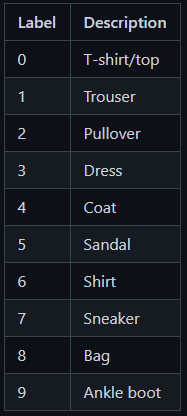


In [4]:
(X_train_raw, y_train), (X_test_raw, y_test) = fashion_mnist.load_data()  #Cargo los dataset de entrenamiento y testeo.

#Reshapeo para obtener un vector de 784 elementos (features) por cada imagen (samples).
X_train = X_train_raw.reshape(60000, -1) #No toco el número de samples, 60000, pero reshapeo las demás dimensiones.
X_test = X_test_raw.reshape(10000, -1) #No toco el número de samples, 60000, pero reshapeo las demás dimensiones.

X_train = X_train.astype('float32') #Transformo el tipo de datos a "float32".
X_test = X_test.astype('float32') # transformo el tipo de datos a "float32".

#Normalizo por el máximo valor que pueden tener los pixels para que los valores queden entre 0 y 1.
X_train = X_train/255.0
X_test = X_test/255.0
#Esto es clave, porque para poder hacer PCA más tarde voy a necesitar los datos estandarizados.

#Imprimo el formato en que quedan las matrices de entrenamiento y testeo.
print("Formato de mi matriz de entrenamiento", X_train.shape)
print("Formato de mi matriz de testeo", X_test.shape)

Formato de mi matriz de entrenamiento (60000, 784)
Formato de mi matriz de testeo (10000, 784)


**Primer paso: PCA**

Necesito hacer descomposición en componentes principales sobre la matriz de datos de entrenamiento.

First things first: antes de hallar las componentes principales del dataset es importante estandarizar las variables restándole la media y dividiendo por la desviación estándar. Así que creo un estandarizador y ajusto con su ayuda los datos.

In [5]:
std_scale = StandardScaler() #Creo el estandarizador 
#Ajustamos el estandarizador
std_scale.fit(X_train)

#Aplico el estandarizador y obtengo las matrices de features ya escaleadas
X_escaleado = std_scale.transform(X_train)
X_test_escaleado = std_scale.transform(X_test)

Ahora sí, aplico efectivamente la descomposición en componentes principales, creando primero el modelo y luego ajustándolo a los datos:

In [6]:
#Creo el modelo. Si no especifico el número de componentes, tengo tantos como features en el dataset.
pca = PCA(n_components = None)
pca_test = PCA(n_components= None)
#Ajusto el modelo a los datos escaleados.
pca.fit(X_escaleado)
pca_test.fit(X_test_escaleado)
#Obtengo la descripción de los datos en el espacio de componentes principales.
X_pca = pca.transform(X_escaleado)
X_test_pca = pca_test.transform(X_test_escaleado)
print('Dimensiones de la matriz de entrenamiento en componentes principales: {}'.format(X_pca.shape))
print(X_pca)
print('Dimensiones de la matriz de evaluación en componentes principales: {}'.format(X_test_pca.shape))
print(X_test_pca)

Dimensiones de la matriz de entrenamiento en componentes principales: (60000, 784)
[[-8.0117321e-01  2.0866760e+01 -1.2945171e+01 ... -1.1026844e-01
  -1.4078691e-02  5.9457563e-02]
 [ 1.7074207e+01 -4.9685173e+00 -2.0778544e+00 ...  1.4396225e-02
  -8.7959655e-03 -6.5454561e-03]
 [-9.6016407e+00 -1.2296110e+01  1.0822548e+00 ...  3.1704009e-03
   7.9233544e-03  1.4937655e-02]
 ...
 [ 9.3776636e+00 -1.3105858e+01 -8.8382721e+00 ...  2.7277462e-02
  -4.5000674e-04  5.0364994e-04]
 [-9.6456366e+00 -7.0952973e+00  6.9453030e+00 ...  4.7226455e-03
   7.9852100e-03 -1.8133090e-03]
 [-2.1317078e+01 -1.7413688e+00  5.4762945e+00 ... -1.0378803e-01
  -1.7314008e-02 -1.0174326e-02]]
Dimensiones de la matriz de evaluación en componentes principales: (10000, 784)
[[-1.6806435e+01  7.2065015e+00 -2.3743882e+00 ...  1.2777187e-02
  -5.1767983e-02  1.9039208e-02]
 [ 2.2242023e+01  9.5446663e+00  9.8665962e+00 ...  2.0171031e-02
   7.1631372e-04 -3.5237633e-03]
 [ 3.9113188e+00 -1.6741581e+01 -8.6239

La matriz anterior me da la descripción de los datos en el espacio de las 784 componentes principales.

**Segundo paso: ¿qué onda la varianza explicada para mi PCA?**

Las componentes principales de PCA están ordenadas crecientemente en cuanto a la cantidad de información que aportan, es decir de acuerdo a la fracción de varianza que cada una explica. Puedo ver cuánto aporta cada componente, como también cuánto es el acumulado de todas las componentes mediante los siguientes gráficos:

Text(0.5, 0, 'Cantidad de componentes principales')

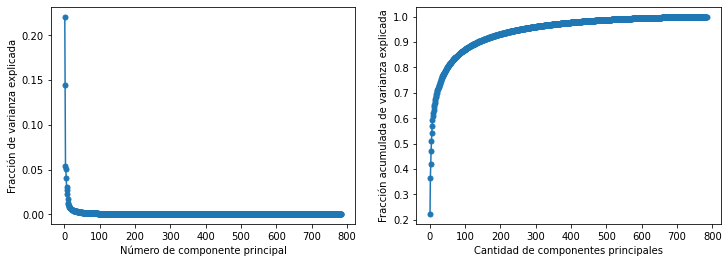

In [7]:
#Con .explained_variance_ratio_ veo la fracción de información que aporta cada componente.
evr = pca.explained_variance_ratio_

#Grafico la fracción de varianza que aporta cada componente y la información acumulada.
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(range(1, len(evr) + 1), evr, '.-', markersize = 10)
ax[0].set_ylabel('Fracción de varianza explicada')
ax[0].set_xlabel('Número de componente principal')

#Calculo el acumulado con la función cumsum de numpy.
varianza_acumulada = np.cumsum(evr)

ax[1].plot(range(1, len(evr) + 1), varianza_acumulada, '.-', markersize = 10)
ax[1].set_ylabel('Fracción acumulada de varianza explicada')
ax[1].set_xlabel('Cantidad de componentes principales')

**Tercer paso: ¿qué onda las primeras 5 componentes de mi PCA?**

Ahora me va a interesar ver qué significan las primeras 5 componentes, información que se encuentra contenida en la lista .pca.components_ del modelo ya ajustado. 
Las primeras cinco componentes en orden de varianza explicada:


In [8]:
print('PCA1 = {}'.format(pca.components_[0]))
print('PCA2 = {}'.format(pca.components_[1]))
print('PCA3 = {}'.format(pca.components_[2]))
print('PCA4 = {}'.format(pca.components_[3]))
print('PCA5 = {}'.format(pca.components_[4]))

PCA1 = [ 1.78220798e-04  1.02303922e-03  2.18623877e-03  2.73162127e-03
  3.62959877e-03  4.87871002e-03  5.87276369e-03  8.77212267e-03
  1.32618314e-02  1.78836565e-02  2.10598316e-02  2.65244879e-02
  3.12801376e-02  3.10580488e-02  3.09650768e-02  3.19998637e-02
  3.06740943e-02  2.40477491e-02  1.78125054e-02  1.38929030e-02
  9.34891962e-03  5.48981363e-03  3.28900851e-03  2.31581856e-03
  2.52715824e-03  1.86617661e-03  7.68999453e-04  1.65038276e-04
  7.69128907e-04  1.14138948e-03  2.00260500e-03  4.49428381e-03
  6.00285083e-03  9.39761754e-03  1.69942621e-02  2.55927406e-02
  3.32048647e-02  3.85467447e-02  4.11062576e-02  4.79770266e-02
  4.94358093e-02  4.65322584e-02  4.53206897e-02  4.85142320e-02
  5.01927435e-02  4.51442562e-02  3.88204306e-02  3.48120518e-02
  2.73831394e-02  1.74049027e-02  8.41055159e-03  4.07571346e-03
  3.80141730e-03  3.35732009e-03  1.93100586e-03  5.08011028e-04
  9.75769828e-04  1.78298040e-03  3.28275538e-03  5.89309679e-03
  9.44828521e-03  

Visualizo las primeros cinco componentes en orden de varianza explicada.

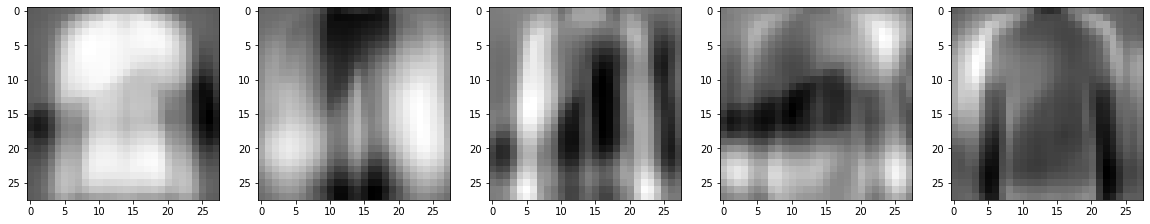

In [9]:
primeras_5_componentes = [pca.components_[0],pca.components_[1],pca.components_[2],pca.components_[3],pca.components_[4]]
primeras_5_componentes = np.array(primeras_5_componentes)
primeras_5_componentes = primeras_5_componentes.reshape(5,28,28)
fig, ax = plt.subplots(1, 5, figsize = (20, 10)) #Seteo el tamaño de la figura.
ax[0].imshow(primeras_5_componentes[0], interpolation='none', cmap="gray") #Plotea la imagen en formato (28,28) para imagenes en escala de grises.
ax[1].imshow(primeras_5_componentes[1], interpolation='none', cmap="gray") #Plotea la imagen en formato (28,28) para imagenes en escala de grises.
ax[2].imshow(primeras_5_componentes[2], interpolation='none', cmap="gray") #Plotea la imagen en formato (28,28) para imagenes en escala de grises.
ax[3].imshow(primeras_5_componentes[3], interpolation='none', cmap="gray") #Plotea la imagen en formato (28,28) para imagenes en escala de grises.
ax[4].imshow(primeras_5_componentes[4], interpolation='none', cmap="gray") #Plotea la imagen en formato (28,28) para imagenes en escala de grises.

**Cuarto paso:**

Creo una figura que muestre las reconstrucciones obtenidas para las diferentes cantidades de componentes indicadas por la consigna: 2, 10, 25, 50 y 100.

Para eso, recorro el vector que indica dichas cantidades de componentes, haciendo PCA para la cantidad indicada según la iteración y produciendo una imagen que permita visualizarlo.


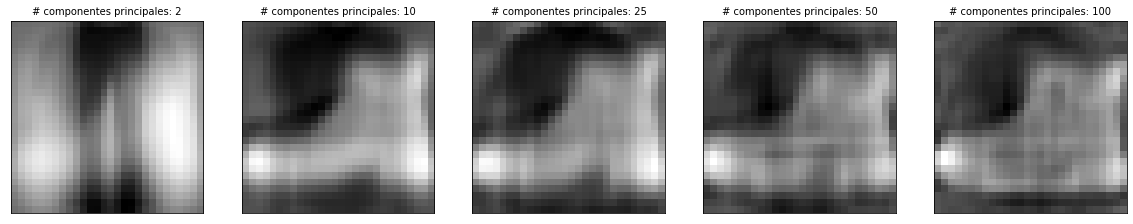

In [10]:
fig, ax = plt.subplots(1, 5, figsize = (20, 10)) #Seteo el tamaño de la figura.

fig_index = 0 #Indice para indicar dónde hacer la figura.

#Recorro un vector que indica la cantidad de componentes a tener en cuenta para el PCA en cada iteración.
for p in [2, 10, 25, 50, 100]:
  pca = PCA(n_components = p) #Creo el PCA para la p cantidad de componentes indicada en la iteración.
  #Ajuste y transformación de los datos.
  pca.fit(X_escaleado)
  X_pca_paso_cuatro = pca.transform(X_escaleado)
  #Reconstrucción de la imagen desde el espacio reducido.
  X_r = pca.inverse_transform(X_pca_paso_cuatro)
  #Ploteo de la imagen reconstruida con el mismo código de antes.
  ax[fig_index].imshow(X_r[0].reshape(28,28), interpolation='none', cmap="gray") #Ploteo la imagen en formato (28,28) para imagenes en escala de grises.
  ax[fig_index].set_title("# componentes principales: {}".format(p), fontsize = 10) #Pongo el título a los plots.
  ax[fig_index].set_xticks([]) #Le saco los ticks en el eje X.
  ax[fig_index].set_yticks([]) #Le saco los ticks en el eje Y.

  fig_index = fig_index + 1

plt.show()

**Quinto paso:**

 Visualizo los datos en un espacio de dimensión reducida formado por la 1era vs. la 2da componentes principales, usando scatterplot.

Text(0, 0.5, 'Segunda componente principal')

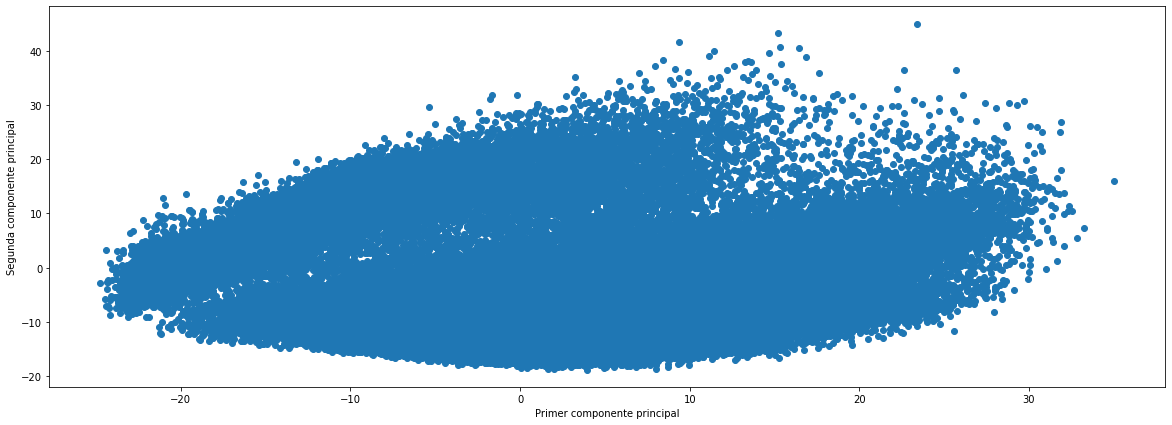

In [11]:
fig, ax = plt.subplots(figsize = (20, 7))

#Realizo un scatter plot de cada uno de los datos.
ax.scatter(X_pca[:, 0], X_pca[:, 1])

#Le agrego labels a los ejes.
ax.set_xlabel('Primer componente principal')
ax.set_ylabel('Segunda componente principal')

Ok, un manchón enorme y bastante poco claro...

**Sexto paso:**

Hago k-means con k=2 sobre los datos del espacio 2D formado por la primera y segunda componente principal. Visualizo algunos ejemplos correspondientes a cada uno de los clusters para entender a dónde fue a parar cada tipo de prenda en los clusters.

Primero creo el modelo para 2 componentes.

In [12]:
# Creo el modelo de PCA con 2 componentes.
pca = PCA(n_components = 2)

# Ajusto y transformo los datos
pca.fit(X_escaleado)
X_pca_paso_seis = pca.transform(X_escaleado)

Ahora sí, hago k-means

In [13]:
#Ya creado y ajustado el modelo a los datos escaleados en el recorte de script anterior, basta ahora con crear el modelo para K-means.

#Creo el modelo KMeans con k = 2.
kmeans = KMeans(n_clusters=2)
#Ajusto el modelo a los datos reducidos en componentes principales.
kmeans.fit(X_pca_paso_seis)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Veo ahora un par de ejemplitos

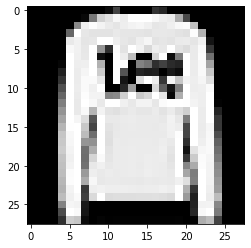

In [14]:
plt.imshow(X_test[1].reshape(28,28), interpolation='none', cmap="gray")

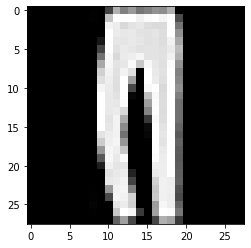

In [15]:
plt.imshow(X_test[2].reshape(28,28), interpolation='none', cmap="gray")

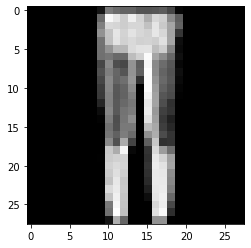

In [16]:
plt.imshow(X_test[3].reshape(28,28), interpolation='none', cmap="gray")

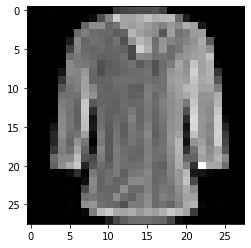

In [17]:
plt.imshow(X_test[4].reshape(28,28), interpolation='none', cmap="gray")

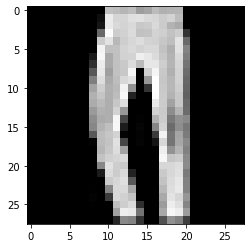

In [18]:
plt.imshow(X_test[5].reshape(28,28), interpolation='none', cmap="gray")

Creo que apunta a eso el ejercicio... ndeah

**Séptimo paso:**

Usando los ids del clustering como etiquetas, entrenar un modelo KNN (K=5) usando los datos de entrenamiento (con todos los features, no solo las primeras dos componentes principales).


Entreno KNN:

In [19]:
#Ahora si, hago KNN
clf = KNeighborsClassifier(n_neighbors=5) #Clasificador de KNN
clf.fit(X_pca, kmeans.labels_) #Una sola vez

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

**Octavo paso:**

Armo un nuevo vector de etiquetas que reemplace a y_test, y tenga 0 donde ese ejemplo iría al cluster 0 y 1 si iría al cluster 1 (los clusters obtenidos con k-means).

Para poder ver a dónde va cada etiqueta hago un poco de inspección visual primero. 
Lo que se observa es que un cluster contiene prendas de vestir (labels 0, 1, 2, 3 y 4) y en el otro hay accesorios como zapatos o bolsos (labels 5, 6, 7, 8 y 9). Así que vamos a separarlos así:

In [20]:
y_test_nuevo = []    #Genero una lista vacía
for i in range(len(y_test)):      #Voy a iterar a lo largo de toda la lista de testeo.
  if y_test[i] in [5,6,7,8,9]:      #Si tiene por label los valores aquí nombrados.
    y_test_nuevo += [0]           #Lo asigno al cluster 0.
  else:
    y_test_nuevo += [1]           #Y si no, al 1.

**Noveno paso:**

Ahora aplico el modelo KNN a datos del dataset de evaluación. Lo voy a hacer sólo con los primeros 1000 para que no tarde tanto. Usando las ids obtenidas mediante el procedimiento del paso anterior, y las predichas por KNN, construyo una matriz de confusión para evaluar la performance del clasificador KNN.

In [21]:
y_test_nuevo = np.array(y_test_nuevo)

y_prediccion = clf.predict(X_test_escaleado[0:1000])
conf_mat = cm(y_test_nuevo[0:1000], y_prediccion)
print(conf_mat)

[[460   9]
 [528   3]]
